<a href="https://colab.research.google.com/github/marendtz/ModelNER/blob/master/XLMR_finetune_pan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Preparations**

In [1]:
# for debugging: clean up model
import shutil
try:
  shutil.rmtree('/content/xlm-roberta-base-finetuned-panx-en')
except:
  print("no such folder")

no such folder


In [2]:
# get github access token for collab
import getpass
token = getpass.getpass()

··········


In [3]:
# clean workdir
%cd /content/
%rm -r /content/*
%ls -la
%pwd

/content
total 16
drwxr-xr-x 1 root root 4096 Jun 16 07:21 ./
drwxr-xr-x 1 root root 4096 Jun 16 07:13 ../
drwxr-xr-x 4 root root 4096 Jun 14 18:26 .config/


'/content'

In [4]:
# clone github repo
!git clone https://{token}@github.com/marendtz/ModelNER.git

Cloning into 'ModelNER'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (67/67), done.
remote: Total 75 (delta 41), reused 21 (delta 7), pack-reused 0
Unpacking objects: 100% (75/75), 1.13 MiB | 4.34 MiB/s, done.


In [6]:
# check python version
!python --version

Python 3.10.12


In [5]:
# install dependencies
%pip install -r /content/ModelNER/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 69.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.6/485.6 kB 48.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 32.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.2/56.2 MB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 110.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 84.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 

In [7]:
# adjust pickle version used, since different version throws error with ray backend for hyperparameter optimization
!pip install pickle5==0.0.10
import pickle5 as pickle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.6/133.6 kB 15.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pickle5: filename=pickle5-0.0.10-cp310-cp310-linux_x86_64.whl size=256402 sha256=8a30e1d16c2603357218dac9038df51e9020e4ab7053406d1adadf8387bd7adc
  Stored in directory: /root/.cache/pip/wheels/bf/bd/b7/5878d60e6e87179a28ca3ae428fcb19c2983c6662786c3888b
Successfully built pickle5


In [15]:
# import packages
from collections import defaultdict
import pandas as pd
import numpy as np
from datasets import load_dataset_builder, get_dataset_config_names, load_dataset, DatasetDict

from transformers import AutoTokenizer, TrainingArguments, DataCollatorForTokenClassification, Trainer
import nltk.data
nltk.download('punkt')

import torch.nn as nn
from transformers import XLMRobertaConfig, AutoConfig, XLMRobertaForTokenClassification
from transformers.modeling_outputs import TokenClassifierOutput

from huggingface_hub import notebook_login
from seqeval.metrics import f1_score, precision_score, recall_score, accuracy_score, classification_report
from seqeval.scheme import IOB2


from torch.nn.functional import cross_entropy
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

import matplotlib.pyplot as plt
import numpy as np


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


**Get and Analyze dataset from Huggingface**

In [9]:
# login to HugginFace to enable upload of model
notebook_login()

In [29]:
# get info from dataset later used for training our model
# load dataset to get the tags used, so we later take the same...
lang = "en"
ds = load_dataset("xtreme", name=f"PAN-X.{lang}")
tags = ds["train"].features["ner_tags"].feature
print(tags)

# generate function to convert name and id of tags
index2tag = {idx: tag for idx, tag in enumerate(tags.names)}
tag2index = {tag: idx for idx, tag in enumerate(tags.names)}
print(index2tag)
print(tag2index)

  0%|          | 0/3 [00:00<?, ?it/s]

ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None)
{0: 'O', 1: 'B-PER', 2: 'I-PER', 3: 'B-ORG', 4: 'I-ORG', 5: 'B-LOC', 6: 'I-LOC'}
{'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3, 'I-ORG': 4, 'B-LOC': 5, 'I-LOC': 6}


In [ ]:
# helper steps for later (aggregating the test steps from before)
def tag_text(text, tags, model, tokenizer):
  # Get tokens with special characters
  tokens = tokenizer(text).tokens()
  # Encode the sequence into IDs
  input_ids = xlmr_tokenizer(text, return_tensors="pt").input_ids.to(device)
  # Get predictions as distribution over 7 possible classes
  outputs = model(input_ids)[0]
  # Take argmax to get most likely class per token
  predictions = torch.argmax(outputs, dim=2)
  # Convert to DataFrame
  preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
  return pd.DataFrame([tokens, preds], index=["Tokens", "Tags"])

**Prepare input data for following training of the model XLMRobertaForTokenClassification (with our config=labels, device, ...)**

In [11]:
# show how labels are given in Pan-X subsets from the XTREME dataset and use the same
xtreme_subsets = get_dataset_config_names("xtreme")
print(f"XTREME has {len(xtreme_subsets)} configurations")

# PAN-X subsets within XTREME dataset
panx_subsets = [s for s in xtreme_subsets if s.startswith("PAN")]
print(f"PAN-X has {len(panx_subsets)} configurations")


XTREME has 183 configurations
PAN-X has 40 configurations


In [12]:
# prepare dataset
panx_ch = defaultdict(DatasetDict)

langs = ["en"] # e.g. ["de","en"]
fracs = [1.0] # e.g. [0.5,0.5]
# panx_ch contains keys for each language and one level lower keys for all splits - here only eng and all data is selected
for lang, frac in zip(langs, fracs):
    # Load monolingual corpus
    ds = load_dataset("xtreme", name=f"PAN-X.{lang}")
    # Shuffle and downsample each split according to spoken proportion
    for split in ds:
        panx_ch[lang][split] = (
            ds[split]
            .shuffle(seed=0)
            .select(range(int(frac * ds[split].num_rows))))
print(panx_ch)
print("Example element in Pan-X Dataset:")
panx_ch_element = panx_ch["en"]["train"][123]
for key, value in panx_ch_element.items():
    print(f"{key}: {value}")

  0%|          | 0/3 [00:00<?, ?it/s]

defaultdict(<class 'datasets.dataset_dict.DatasetDict'>, {'en': DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 20000
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
})})
Example element in Pan-X Dataset:
tokens: ['Anders', 'Oechsler', '(', 'REtires', ')']
ner_tags: [1, 2, 0, 0, 0]
langs: ['en', 'en', 'en', 'en', 'en']


In [13]:
# show info about tag feature --> we already defined the varibale tags earlier
# --> DatasetDict holds information about all features used (like infos on columns in dataframe)
print('----------features----------------')
print(panx_ch["en"]["train"].features)
print('----------feature ner_tags----------------')
print(panx_ch["en"]["train"].features["ner_tags"].feature)


----------features----------------
{'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None), 'ner_tags': Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None), length=-1, id=None), 'langs': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)}
----------feature ner_tags----------------
ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None)


In [14]:
# examples
print(panx_ch["en"]["train"][10])
print(panx_ch["en"]["train"][10]["tokens"])
print(panx_ch["en"]["train"][10]["ner_tags"])

{'tokens': ['Its', 'source', 'is', 'near', 'Mega', 'Dereio', '.'], 'ner_tags': [0, 0, 0, 0, 5, 6, 0], 'langs': ['en', 'en', 'en', 'en', 'en', 'en', 'en']}
['Its', 'source', 'is', 'near', 'Mega', 'Dereio', '.']
[0, 0, 0, 0, 5, 6, 0]


Count PER-Tag: 18355
Count ORG-Tag: 18844
Count LOC-Tag: 18836


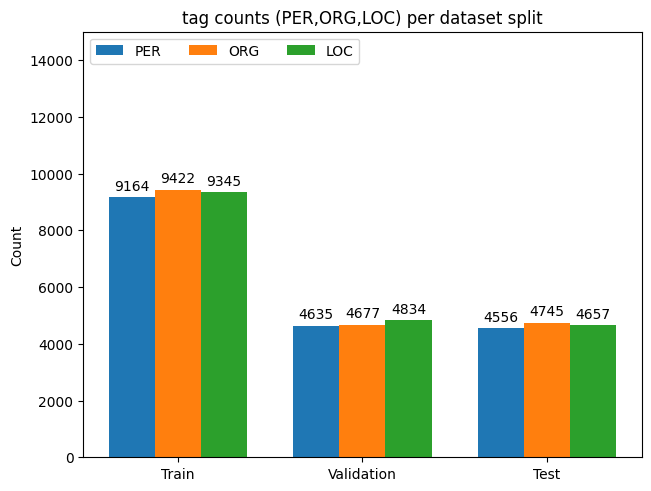

In [22]:
# getting info about tag-counts of labeled data
count_per = 0
count_org = 0
count_loc = 0
for sentence in panx_ch["en"]["train"]:
  tags = sentence["ner_tags"]
  count_per = count_per + tags.count(1)
  count_org = count_org + tags.count(3)
  count_loc = count_loc + tags.count(5)
train_count_per= count_per
train_count_org= count_org
train_count_loc= count_loc

count_per = 0
count_org = 0
count_loc = 0

for sentence in panx_ch["en"]["validation"]:
  tags = sentence["ner_tags"]
  count_per = count_per + tags.count(1)
  count_org = count_org + tags.count(3)
  count_loc = count_loc + tags.count(5)
val_count_per= count_per
val_count_org= count_org
val_count_loc= count_loc

count_per = 0
count_org = 0
count_loc = 0

for sentence in panx_ch["en"]["test"]:
  tags = sentence["ner_tags"]
  count_per = count_per + tags.count(1)
  count_org = count_org + tags.count(3)
  count_loc = count_loc + tags.count(5)

test_count_per= count_per
test_count_org= count_org
test_count_loc= count_loc

print(f"Count PER-Tag: {train_count_per+val_count_per+test_count_per}")
print(f"Count ORG-Tag: {train_count_org+val_count_org+test_count_org}")
print(f"Count LOC-Tag: {train_count_loc+val_count_loc+test_count_loc}")


splits = ("Train", "Validation", "Test")
split_values = {
    'PER': (train_count_per, val_count_per, test_count_per),
    'ORG': (train_count_org, val_count_org, test_count_org),
    'LOC': (train_count_loc, val_count_loc, test_count_loc),
}

x = np.arange(len(splits))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in split_values.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Count')
ax.set_title('tag counts (PER,ORG,LOC) per dataset split')
ax.set_xticks(x + width, splits)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 15000)

plt.show()

**Set tokenizer**

In [24]:
# setup for tokenization
xlmr_model_name = "xlm-roberta-base"
xlmr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model_name)

**Define helper function for data preparation**

In [25]:
# the library datasets provides a fast way to tokenize dataset objects with the map() operation.
# the returned input ids need to be augmented with the attention mask and the label ids, that encode the information about with token is associated with each NER tag

def tokenize_and_align_labels(examples):
  tokenized_inputs = xlmr_tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)  # sequence is already split in words
  labels = []
  for idx, label in enumerate(examples["ner_tags"]):
    word_ids = tokenized_inputs.word_ids(batch_index=idx) # get word ids to associate subwords
    previous_word_idx = None
    label_ids = []
    for word_idx in word_ids:
      if word_idx is None or word_idx == previous_word_idx:
        label_ids.append(-100) # -100 is chose, since the PyTorch cross-entropy loss class torch.nn.CrossEntropyLoss has an attribute ignore_index, whose value is -100, which is therefor ignored during training
      else:
        label_ids.append(label[word_idx])
      previous_word_idx = word_idx
    labels.append(label_ids)
  tokenized_inputs["labels"] = labels
  return tokenized_inputs

def encode_panx_dataset(corpus):
  return corpus.map(tokenize_and_align_labels, batched=True,remove_columns=['langs', 'ner_tags', 'tokens'])



In [26]:
# encode dataset
panx_en_encoded = encode_panx_dataset(panx_ch["en"])
print("Encoded example:")
print(panx_en_encoded["train"][2])

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Encoded example:
{'input_ids': [0, 9079, 7113, 202104, 11491, 6, 4, 9079, 7113, 15, 5106, 210298, 1104, 151210, 6, 4, 20271, 30839, 6, 167618, 5106, 1388, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': [-100, 5, -100, 6, 6, 0, -100, 5, -100, 0, 0, -100, -100, -100, 0, -100, 0, 3, 4, -100, 0, 0, -100]}


**Define performance measures**

In [27]:
# common approach: results for precision, recall, F1-score
# in NER: all words of an entity need to be predicted correctly in order for a prediction to be counted as correct
# libary seqeval: expects predictions and labels as lists of lists


# during training we need to convert the outputs of the model into such a list that sequeval expects
def align_predictions(predictions, label_ids):
  preds = np.argmax(predictions, axis=2)
  batch_size, seq_len = preds.shape
  labels_list, preds_list = [], []

  for batch_idx in range(batch_size):
    example_labels, example_preds = [], []
    for seq_idx in range(seq_len):
      # Ignore label IDs = -100
      if label_ids[batch_idx, seq_idx] != -100:
        example_labels.append(index2tag[label_ids[batch_idx][seq_idx]])
        example_preds.append(index2tag[preds[batch_idx][seq_idx]])
    labels_list.append(example_labels)
    preds_list.append(example_preds)
  return preds_list, labels_list

# helper function for calculation of F1-score for validation set
def compute_metrics(eval_pred):
  y_pred, y_true = align_predictions(eval_pred.predictions, eval_pred.label_ids)
  return {"f1": f1_score(y_true, y_pred),
          "precision": precision_score(y_true, y_pred),
          "recall": recall_score(y_true, y_pred),
          "accuracy": f1_score(y_true, y_pred)
          #"classification_report": classification_report(y_true, y_pred, mode='strict', scheme=IOB2)  # throws error on hperparameter_search since str
          }


**Finetuning XLM-RoBERTa and Upload to Huggingface**

In [30]:
# hide_output

import torch

# passing keyword arguments to the from_pretrained() method overrides default values
xlmr_config = AutoConfig.from_pretrained(xlmr_model_name,num_labels=tags.num_classes, id2label=index2tag, label2id=tag2index)

# define "device"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [31]:
# docu: https://huggingface.co/docs/transformers/v4.28.1/en/main_classes/trainer#transformers.TrainingArguments
num_epochs = 3
batch_size = 24
learning_rate = 5e-5
weight_decay= 0.01

logging_steps = len(panx_en_encoded["train"]) // batch_size
model_name = f"{xlmr_model_name}-finetuned-panx-en"
training_args = TrainingArguments(output_dir=model_name, log_level="error", num_train_epochs=num_epochs,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  evaluation_strategy="steps", eval_steps=batch_size, # Number of update steps between two evaluations if evaluation_strategy="steps".
                                  save_strategy="steps", save_steps=1e6,
                                  learning_rate=learning_rate, #  The initial learning rate for AdamW optimizer.
                                  weight_decay=weight_decay, # The weight decay to apply (if not zero)
                                  disable_tqdm=False,
                                  logging_strategy="steps", logging_steps=batch_size,  # Number of update steps between two logs if logging_strategy="steps".
                                  push_to_hub=True)

In [32]:
# this model needs to be crated at huggingface:
f"{xlmr_model_name}-finetuned-panx-en"

'xlm-roberta-base-finetuned-panx-en'

In [33]:
# pad each input sequence to the largest sequence length in a batch
data_collator = DataCollatorForTokenClassification(xlmr_tokenizer)

In [34]:
# init method, to avoid initializing a new model for every Trainer (it loads the untrained model and is called at the beginning of the train() call)
def model_init():
  return (XLMRobertaForTokenClassification
          .from_pretrained(xlmr_model_name, config=xlmr_config)
          .to(device))

In [37]:
trainer = Trainer(model_init=model_init, args=training_args,
                  data_collator=data_collator,
                  compute_metrics=compute_metrics,
                  train_dataset=panx_en_encoded["train"],
                  eval_dataset=panx_en_encoded["validation"],
                  tokenizer=xlmr_tokenizer)

/content/xlm-roberta-base-finetuned-panx-en is already a clone of https://huggingface.co/maren-hugg/xlm-roberta-base-finetuned-panx-en. Make sure you pull the latest changes with `repo.git_pull()`.


In [38]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
24,1.264400,0.817467,0.421248,0.369598,0.489679,0.421248
48,0.720900,0.563264,0.481697,0.418967,0.566521,0.481697
72,0.595100,0.467027,0.605884,0.558773,0.661671,0.605884
96,0.447500,0.442492,0.665884,0.633618,0.701612,0.665884
120,0.497800,0.446937,0.637484,0.592957,0.689241,0.637484
144,0.438300,0.409320,0.700302,0.666773,0.737382,0.700302
168,0.414800,0.368846,0.712246,0.687660,0.738654,0.712246
192,0.451300,0.369968,0.723576,0.708127,0.739714,0.723576
216,0.378600,0.366571,0.730411,0.712490,0.749258,0.730411
240,0.425000,0.365239,0.704618,0.687374,0.722748,0.704618


Step,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
24,1.264400,0.817467,0.421248,0.369598,0.489679,0.421248
48,0.720900,0.563264,0.481697,0.418967,0.566521,0.481697
72,0.595100,0.467027,0.605884,0.558773,0.661671,0.605884
96,0.447500,0.442492,0.665884,0.633618,0.701612,0.665884
120,0.497800,0.446937,0.637484,0.592957,0.689241,0.637484
144,0.438300,0.409320,0.700302,0.666773,0.737382,0.700302
168,0.414800,0.368846,0.712246,0.687660,0.738654,0.712246
192,0.451300,0.369968,0.723576,0.708127,0.739714,0.723576
216,0.378600,0.366571,0.730411,0.712490,0.749258,0.730411
240,0.425000,0.365239,0.704618,0.687374,0.722748,0.704618


TrainOutput(global_step=2502, training_loss=0.26952576098872794, metrics={'train_runtime': 1115.0776, 'train_samples_per_second': 53.808, 'train_steps_per_second': 2.244, 'total_flos': 1178415902403696.0, 'train_loss': 0.26952576098872794, 'epoch': 3.0})

In [40]:
trainer.push_to_hub(commit_message="Training completed!")

Upload file runs/Jun16_07-34-13_53f71e3bbcf5/events.out.tfevents.1686904588.53f71e3bbcf5.1987.0:  47%|####6   …

Upload file training_args.bin: 100%|##########| 3.87k/3.87k [00:00<?, ?B/s]

To https://huggingface.co/maren-hugg/xlm-roberta-base-finetuned-panx-en
   8bc488c..4531a40  main -> main

   8bc488c..4531a40  main -> main

To https://huggingface.co/maren-hugg/xlm-roberta-base-finetuned-panx-en
   4531a40..b4ba2d0  main -> main

   4531a40..b4ba2d0  main -> main



'https://huggingface.co/maren-hugg/xlm-roberta-base-finetuned-panx-en/commit/4531a4006dac87e5ce48ea108866e52341a64bc6'

In [41]:
# info about trainer log history
metrics_train=trainer.state.log_history
for item in metrics_train:
  print(item)

{'loss': 1.2644, 'learning_rate': 4.9520383693045564e-05, 'epoch': 0.03, 'step': 24}
{'eval_loss': 0.8174670934677124, 'eval_f1': 0.4212478715640963, 'eval_precision': 0.3695976950165404, 'eval_recall': 0.48967906121871907, 'eval_accuracy': 0.4212478715640963, 'eval_runtime': 8.919, 'eval_samples_per_second': 1121.206, 'eval_steps_per_second': 46.754, 'epoch': 0.03, 'step': 24}
{'loss': 0.7209, 'learning_rate': 4.904076738609113e-05, 'epoch': 0.06, 'step': 48}
{'eval_loss': 0.5632641315460205, 'eval_f1': 0.48169742141011, 'eval_precision': 0.4189669594312003, 'eval_recall': 0.566520571186201, 'eval_accuracy': 0.48169742141011, 'eval_runtime': 9.0131, 'eval_samples_per_second': 1109.493, 'eval_steps_per_second': 46.266, 'epoch': 0.06, 'step': 48}
{'loss': 0.5951, 'learning_rate': 4.8561151079136694e-05, 'epoch': 0.09, 'step': 72}
{'eval_loss': 0.4670272469520569, 'eval_f1': 0.6058840664142149, 'eval_precision': 0.5587726105904125, 'eval_recall': 0.6616711437862294, 'eval_accuracy': 0.60